# **Submission 2 - Model Machine Learning with Date Time Series**

## **Muhammad Theda Amanda**

Dataset: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

### **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import os, zipfile
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

### **Import Dataset with Kaggle**

In [ ]:
!pip install -q kaggle

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d robikscube/hourly-energy-consumption

 88% 10.0M/11.4M [00:00<00:00, 15.1MB/s]
100% 11.4M/11.4M [00:00<00:00, 12.7MB/s]


In [ ]:
local_zip = '/content/hourly-energy-consumption.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

### **Data Loading**

In [ ]:
df = pd.read_csv('/content/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [ ]:
dates = df['Datetime'].values
PJME_MW = df['PJME_MW'].values

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


### **Time Series Plot**

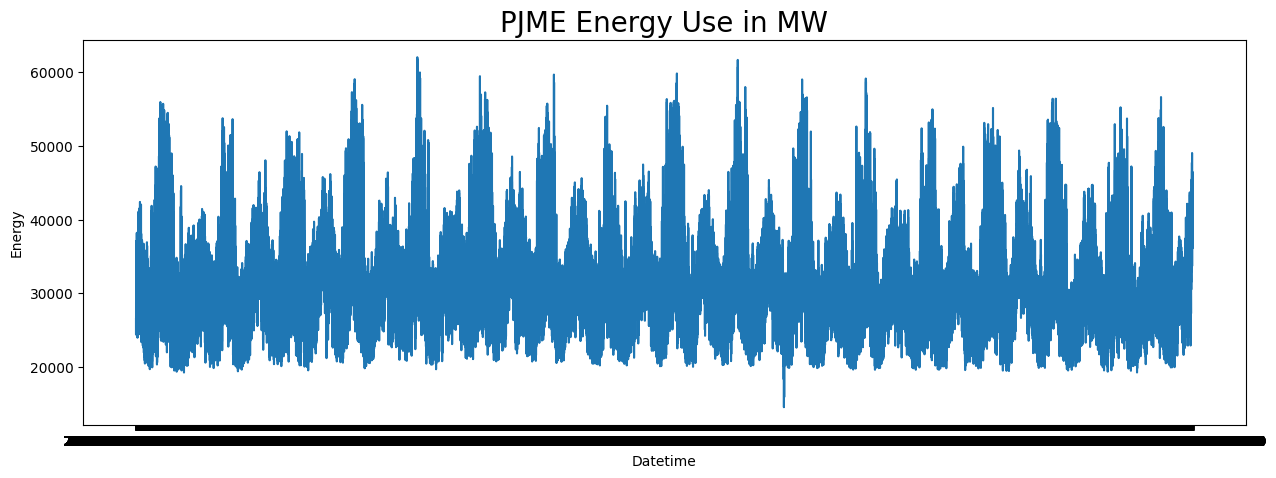

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(dates, PJME_MW)
plt.title('PJME Energy Use in MW', fontsize=20)
plt.xlabel('Datetime')
plt.ylabel('Energy')
plt.show()

### **Modeling**

In [ ]:
PJME_MW  = df['PJME_MW'].values.reshape(-1,1)
PJME_MW

array([[26498.],
       [25147.],
       [24574.],
       ...,
       [42402.],
       [40164.],
       [38608.]])

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
PJME_MW  = scaler.fit_transform(PJME_MW)
PJME_MW.shape

(145366, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(PJME_MW, dates, test_size=0.2, shuffle=False)
print("X_train length:", len(X_train))
print("X_test length:", len(X_test))

X_train length: 116292
X_test length: 29074


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=64, shuffle_buffer=1000)
test_set  = windowed_dataset(X_test, window_size=60, batch_size=64, shuffle_buffer=1000)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          16896     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dropout (Dropout)           (None, None, 30)          0         
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
Total params: 52191 (203.87 KB)
Trainable params: 52191 

### **Compile and Fit Model**

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

In [ ]:
threshold_mae = (PJME_MW.max() - PJME_MW.min()) * 10/100
print("The maximum limit of mae value (10%) from the data is", threshold_mae)

The maximum limit of mae value (10%) from the data is 0.1


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('mae') < threshold_mae) and (logs.get('val_mae') < threshold_mae)):
      print("MAE < 10%")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(train_set, epochs=100, validation_data=test_set, verbose=2, callbacks=[callbacks])

Epoch 1/100
1817/1817 - 43s - loss: 0.0168 - mae: 0.1386 - val_loss: 0.0092 - val_mae: 0.1047 - 43s/epoch - 23ms/step
Epoch 2/100
1817/1817 - 40s - loss: 0.0094 - mae: 0.1063 - val_loss: 0.0090 - val_mae: 0.1036 - 40s/epoch - 22ms/step
Epoch 3/100
1817/1817 - 41s - loss: 0.0092 - mae: 0.1047 - val_loss: 0.0089 - val_mae: 0.1028 - 41s/epoch - 22ms/step
Epoch 4/100
1817/1817 - 40s - loss: 0.0089 - mae: 0.1032 - val_loss: 0.0086 - val_mae: 0.1014 - 40s/epoch - 22ms/step
Epoch 5/100
1817/1817 - 38s - loss: 0.0087 - mae: 0.1016 - val_loss: 0.0084 - val_mae: 0.0997 - 38s/epoch - 21ms/step
Epoch 6/100
MAE < 10%
1817/1817 - 38s - loss: 0.0083 - mae: 0.0998 - val_loss: 0.0081 - val_mae: 0.0979 - 38s/epoch - 21ms/step


### **Plot MAE & Loss**

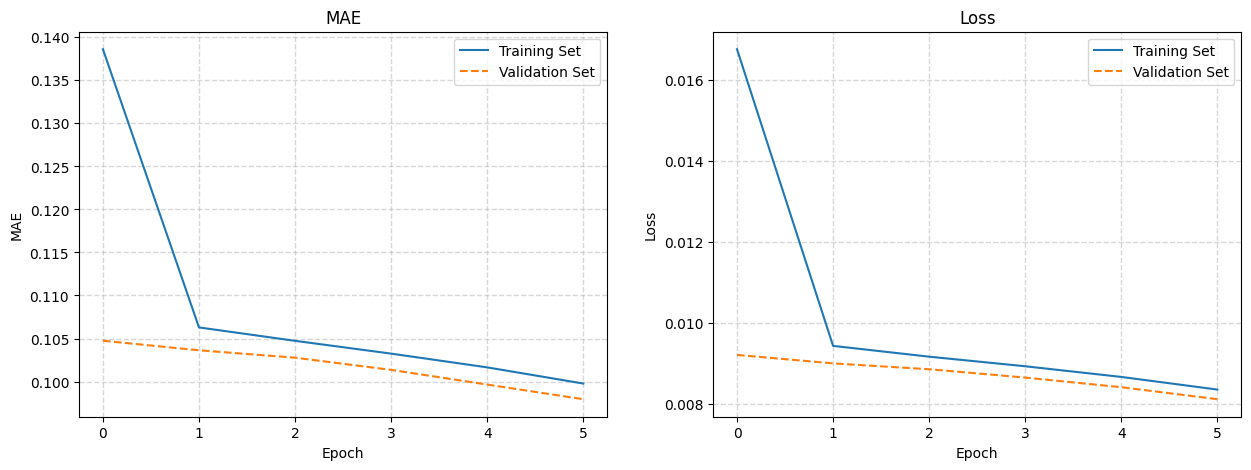

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'], linestyle='--')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'])
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle='--')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'])
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()